In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings
import numpy as np
from copy import deepcopy

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from lib.prepare_data import get_predict_set
from lib.merge import prepare_train_show


In [3]:
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = sys.executable

spark = SparkSession.builder.appName("renovation").getOrCreate()


In [4]:
# import files
# File location and type
file_location_array = [
    {
        "location": "../training/pred_renov.csv",
        "name": "pred_renov_no_diff",
        "delimiter": ",",
    },
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"},
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )


In [5]:
# cast variables if necessary
training_renov_no_diff = (
    dataframes["pred_renov_no_diff"].withColumns({
        "surface": (
            F.when(F.col("surface") == "null", np.nan).otherwise(
                F.col("surface").cast("int")
            )
        ),
        "heating_production": (
            F.when(F.col("heating_production") == "null", np.nan).otherwise(
                F.col("heating_production").cast("int")
            )
        ),
    })
)
dictionary = dataframes["dictionary"]


In [6]:
# linear
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

# hyperparams
from scipy.stats import uniform, randint


0.62309670781893 {'C': 941.4585843529143, 'class_weight': 'balanced', 'max_iter': 1000}
0.7765174897119341 {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 192}
0.7861625514403292 {'learning_rate': 0.10117472624904002, 'n_estimators': 70}


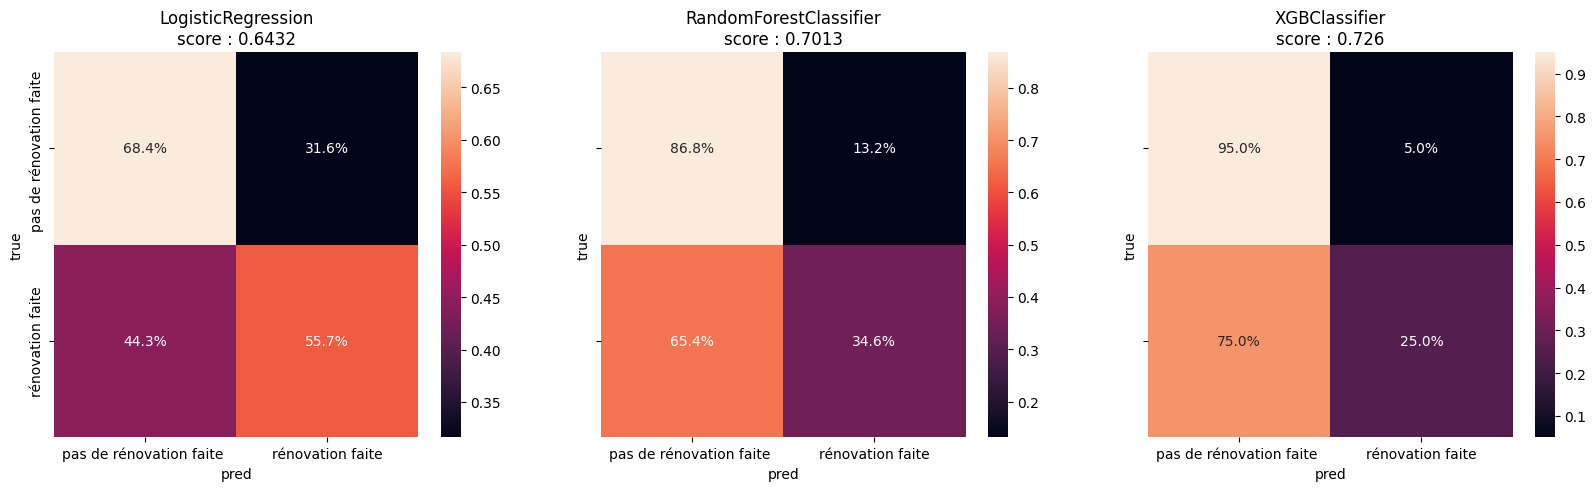

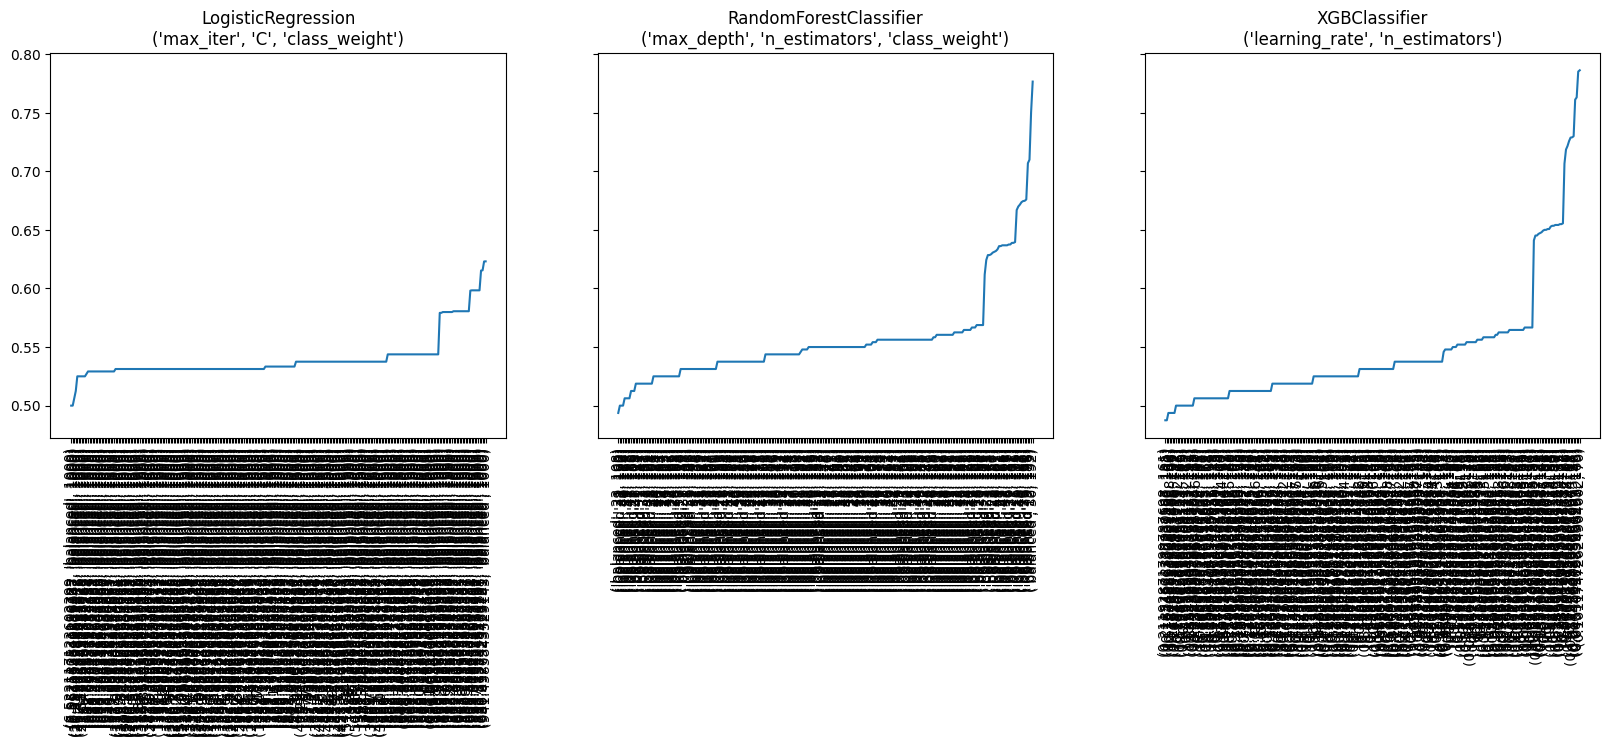

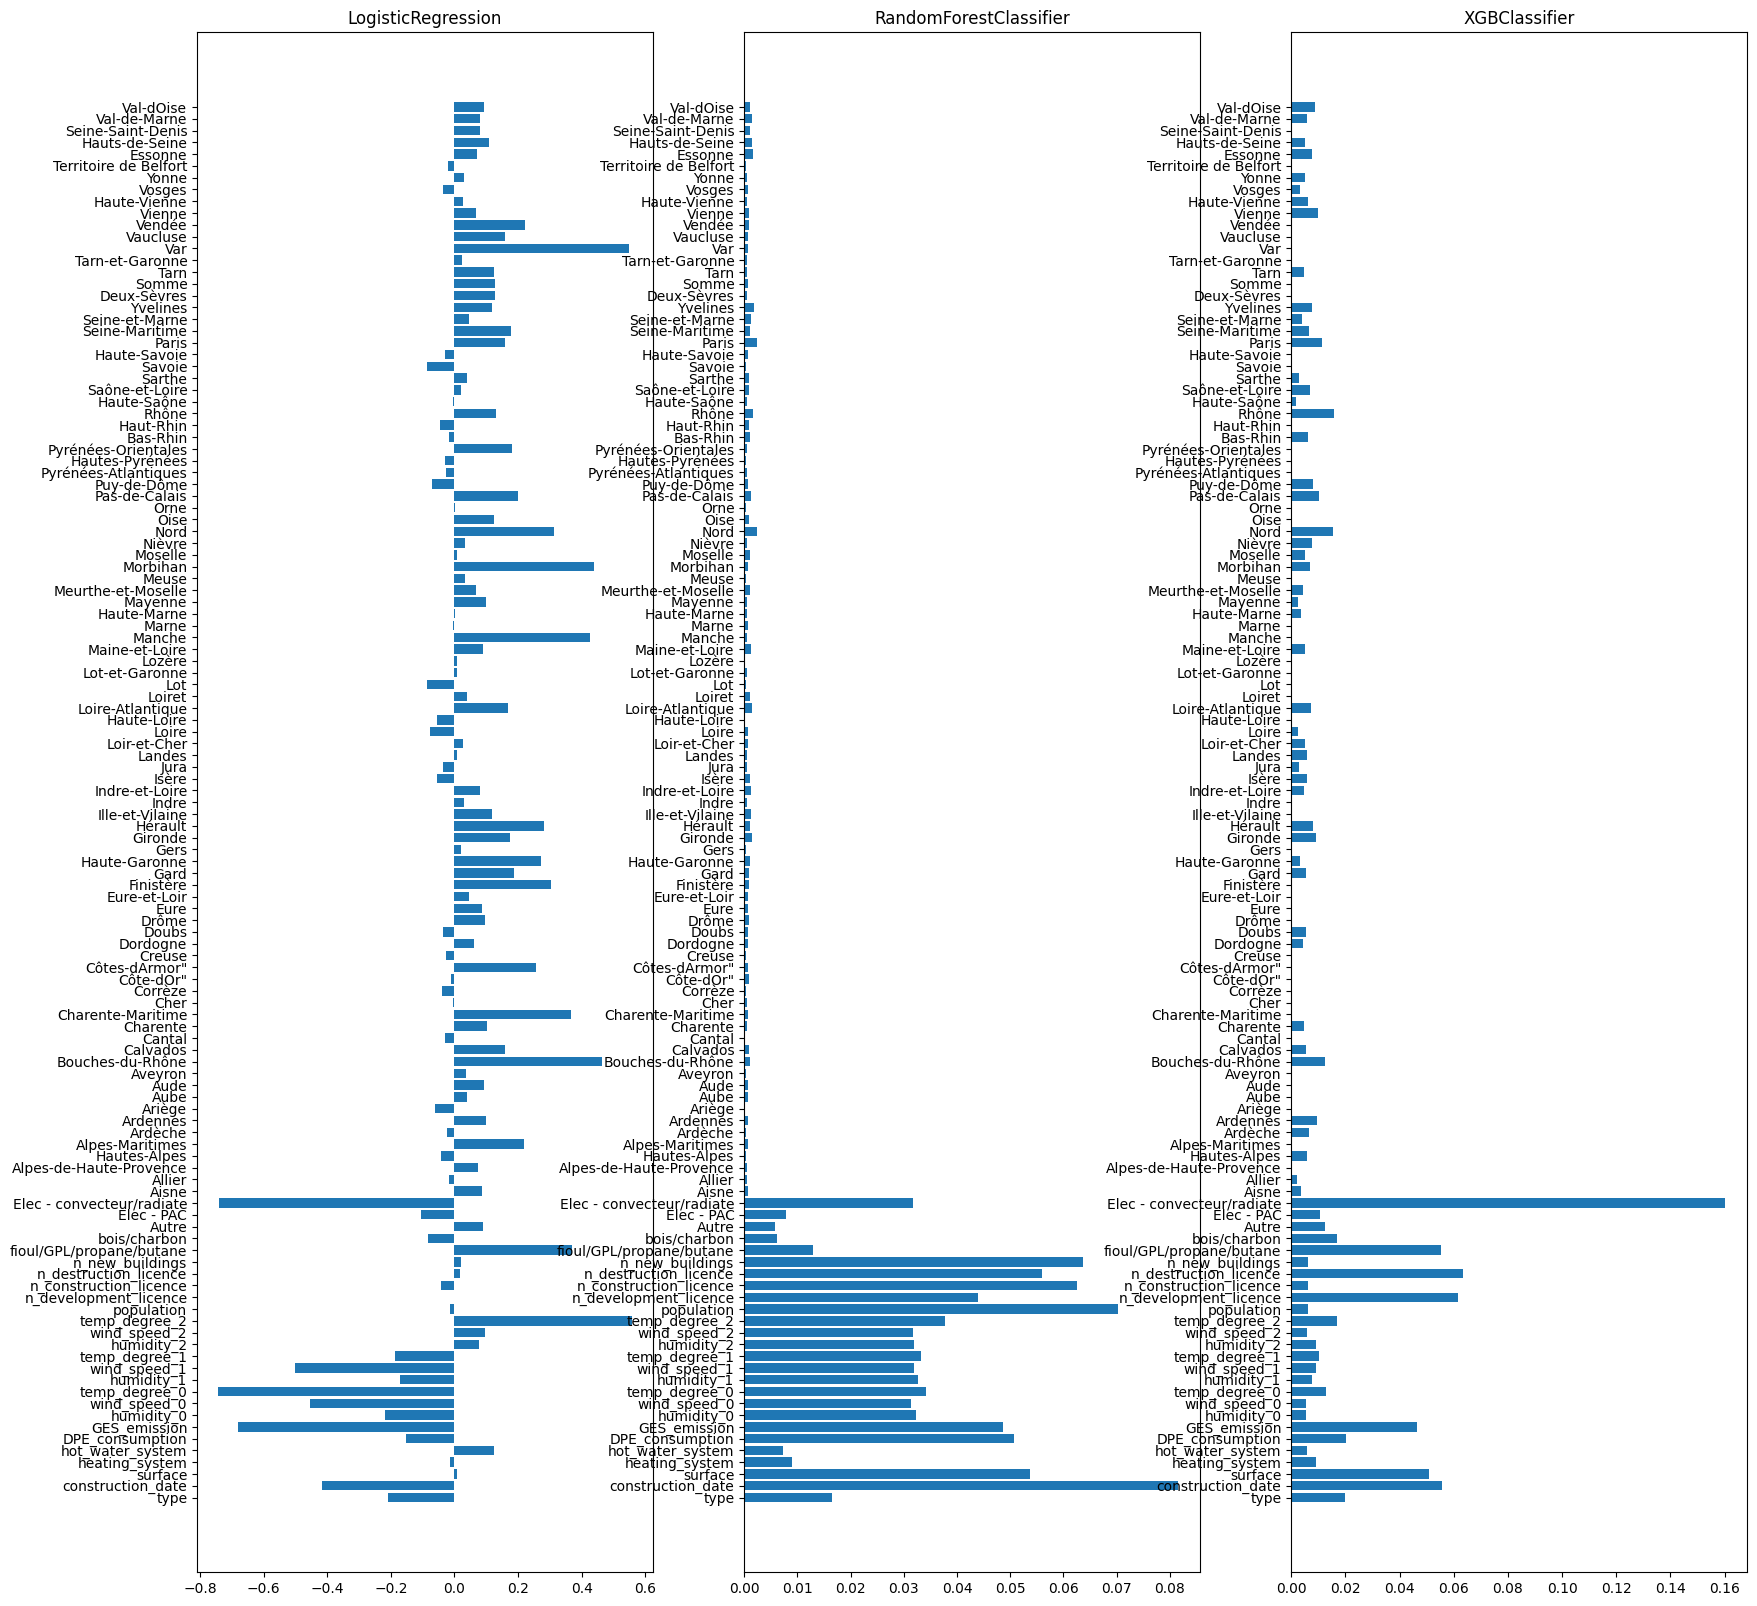

In [20]:
# get best model for the dataset
col_X_hot = [['heating_production', 'department_number'], ['heating_production', 'department_number'], ['heating_production', 'department_number']]
col_y = ["has_done_renov"]
col_X_not_hot = [
    [col[0] for col in training_renov_no_diff.dtypes if col[0] not in col_X_hot[i] + col_y]
    for i in range(len(col_X_hot))
]

categorical_features = [0, 1, 3, 4, 5, -2]


hyperparams_models = [
    {
        "max_iter": [1000],
        "C": uniform(1, 1000),
        "class_weight": ["balanced"],
    },
    {
        "max_depth": randint(1, 50),
        "n_estimators": randint(100, 200),
        "class_weight": ["balanced"],
    },
    {
        "learning_rate": uniform(0.03, 0.3),
        "n_estimators": randint(50, 200),
    },
]
models = {
    "LogisticRegression": LogisticRegression,
    "RandomForestClassifier": RandomForestClassifier,
    "XGBClassifier": XGBClassifier,
}

best_models_no_diff = prepare_train_show(
    training_renov_no_diff,
    dictionary,
    categorical_features,
    col_X_hot,
    col_X_not_hot,
    col_y,
    False,
    True,
    hyperparams_models,
    models,
    random_state=42,
    test_size=0.4,
    scoring="f1_micro",
    smote=True
)


In [21]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# prepare data
from sklearn.model_selection import train_test_split
from lib.prepare_data import prepare_dataset

# scoring and training
from sklearn.metrics import f1_score
from lib.train import train_hyper, choose_params, nb_possibility, iterate_params
from sklearn.model_selection import cross_val_score

# insights
from lib.show import show_matrix

In [24]:
print(best_models_no_diff)


{'LogisticRegression': [LogisticRegression(C=941.4585843529143, class_weight='balanced', max_iter=1000), 0.62309670781893, {'C': 941.4585843529143, 'class_weight': 'balanced', 'max_iter': 1000}], 'RandomForestClassifier': [RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=192), 0.7765174897119341, {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 192}], 'XGBClassifier': [XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10117472624904002,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_chil

In [25]:

# stacking model with sklearn librairy
from sklearn.ensemble import StackingClassifier

col_X_hot = ['heating_production', 'department_number']
col_y = ["has_done_renov"]
col_X_not_hot = [col[0] for col in training_renov_no_diff.dtypes if col[0] not in col_X_hot + col_y]

estimators = [
    ("xgb", best_models_no_diff['XGBClassifier'][0]),
    ("rf", best_models_no_diff['RandomForestClassifier'][0]),
    ("lg", best_models_no_diff['LogisticRegression'][0]),
]

hyperparams_models = [
    {
        "max_depth": [10, 15, 20, 25, 30],
        "n_estimators": [100, 133, 166, 200],
        "class_weight": ["balanced"],
    },
    {
        "learning_rate": [0.01, 0.03, 0.07, 0.1],
        "n_estimators": [30, 50, 70, 90, 110, 130],
    },
]
models = {
    "RandomForestClassifier": RandomForestClassifier,
    "XGBClassifier": XGBClassifier,
}

# iterating over hyperparams
best = {}
X, y, labels = prepare_dataset(training_renov_no_diff, dictionary, col_X_hot, col_X_not_hot, col_y, False, True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

for hyperparams, (model_name, model) in zip(hyperparams_models, models.items()):
    current = [0 for _ in range(len(hyperparams))]
    max_hyper = [len(cut_param) - 1 for cut_param in hyperparams.values()]
    current_params = choose_params(current, hyperparams)
    all_poss = nb_possibility(max_hyper)
    print(all_poss)

    parametrized_model = model(**current_params)
    stack = StackingClassifier(estimators, parametrized_model, cv="prefit")
    # register score
    stack.fit(X_train, y_train)
    score = f1_score(y_test, stack.predict(X_test), average="micro")
    max_score = deepcopy(score)
    best_params = deepcopy(current_params)
    best_model = deepcopy(stack)

    i = 0
    nb_print = (all_poss // 4) + 1
    while not all(np.equal(current, max_hyper)):
        # choose params
        current = iterate_params(current, max_hyper)
        current_params = choose_params(current, hyperparams)
        if i % nb_print == 0:
            print(i, current)
        i += 1
        parametrized_model = model(**current_params)
        stack = StackingClassifier(estimators, parametrized_model, cv="prefit")
        # register score
        stack.fit(X_train, y_train)
        score = f1_score(y_test, stack.predict(X_test), average="micro")

        if score > max_score:
            max_score = deepcopy(score)
            best_params = deepcopy(current_params)
            best_model = deepcopy(stack)
    print(max_score, best_params)
    best[model_name] = {"model": best_model, "params": best_params, "score": score}

20
0 [1, 0, 0]
6 [2, 1, 0]
12 [3, 2, 0]
18 [4, 3, 0]
0.9743333333333334 {'max_depth': 10, 'n_estimators': 166, 'class_weight': 'balanced'}
24
0 [1, 0]
7 [0, 2]
14 [3, 3]
21 [2, 5]
0.9753333333333334 {'learning_rate': 0.01, 'n_estimators': 30}
